# Reconocimiento de edad por CNN 

véase: kaggle.com/abhijitsingh001/predicting-age-of-image-by-cnn

In [6]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,MaxPool2D,Dense,Conv2D,Flatten
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

## Leyendo el dataset 

In [7]:
data = pd.read_csv("age_gender.csv")
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [8]:
def values_to_array(pixels):
    arr = np.array(pixels.split(),'float64')
    arr = arr.reshape(48,48)
    return arr

In [9]:
data["pixels"]=data["pixels"].apply(values_to_array)

## Separando datos para prueba y entrenamiento

In [10]:
train_img, test_img,train_age,test_age = train_test_split(data["pixels"],data["age"],test_size=0.2,random_state=42)

## Visualizacion de la distribucion de los datos

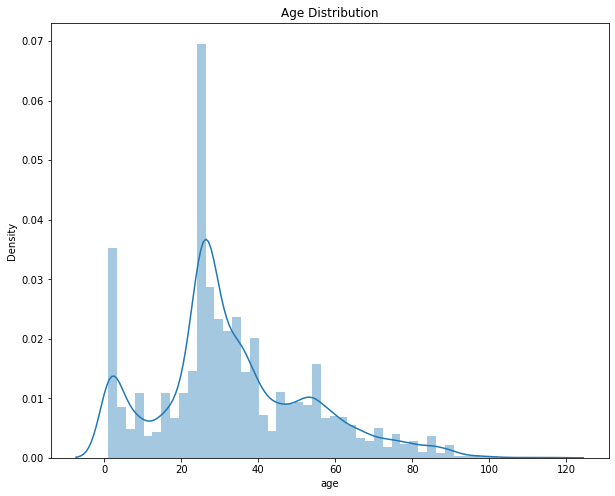

In [12]:
plt.figure(figsize=(10,8))
sns.distplot(train_age)
plt.title("Age Distribution")
plt.show()

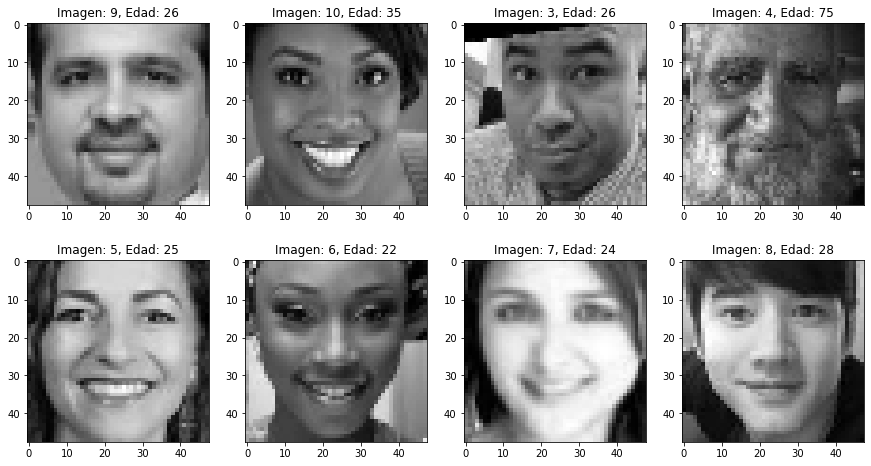

In [15]:
plt.figure(figsize=(15,8))
for i in range(0,10):
    plt.subplot(2,4,(i%8)+1)
    num = np.random.randint(1000)
    plt.title(f"Imagen: {i+1}, Edad: {train_age.iloc[num]}")
    plt.imshow(train_img.iloc[num],cmap='gray')
plt.show()

## Redimensionando los datos

In [16]:
# funcion para crear el array multidimensional o tensor
def change_image_dimension(data):
    data = np.reshape(data.to_list(),(len(data),48,48,1))
    return data

In [17]:
# Creando tensores 
train_img = change_image_dimension(train_img)
test_img = change_image_dimension(test_img)
# Normalizando la intensidad del pixel entre 0 y 1 
train_img = train_img/255.0
test_img = test_img/255.0

## Callback functions

In [18]:
def schedule(epoch,lr):
    if(epoch >= 5):
        return 0.0001
    return 0.001

In [19]:
early_stop = EarlyStopping(monitor='val_mean_absolute_error',patience=2)
learning_rate_scheduler = LearningRateScheduler(schedule)
reduceLR = ReduceLROnPlateau(monitor='val_mean_absolute_error',patience=1,min_lr=0.00001)

# Construcción de la red neuronal convolucional

In [20]:
model = Sequential()
model.add(Conv2D(128,(3,3),activation='relu',input_shape=(48,48,1)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='relu'))

In [21]:
model.compile(optimizer='adam',loss='mse',metrics=[tf.keras.metrics.mean_absolute_error])
r = model.fit(train_img,train_age,validation_data=(test_img,test_age),epochs=15,callbacks=[reduceLR])

Epoch 1/15
593/593 [==============================] - 81s 136ms/step - loss: 170.4084 - mean_absolute_error: 9.4160 - val_loss: 1952.9603 - val_mean_absolute_error: 41.7621
Epoch 2/15
593/593 [==============================] - 83s 140ms/step - loss: 93.6744 - mean_absolute_error: 7.1200 - val_loss: 174.8922 - val_mean_absolute_error: 10.3507
Epoch 3/15
593/593 [==============================] - 86s 146ms/step - loss: 80.2676 - mean_absolute_error: 6.5910 - val_loss: 306.9292 - val_mean_absolute_error: 12.6488
Epoch 4/15
593/593 [==============================] - 87s 147ms/step - loss: 56.8718 - mean_absolute_error: 5.5709 - val_loss: 77.9048 - val_mean_absolute_error: 6.4827
Epoch 5/15
593/593 [==============================] - 88s 149ms/step - loss: 51.4613 - mean_absolute_error: 5.3261 - val_loss: 77.3206 - val_mean_absolute_error: 6.4929
Epoch 6/15
593/593 [==============================] - 89s 150ms/step - loss: 47.0083 - mean_absolute_error: 5.1004 - val_loss: 73.7870 - val_mean_a

## Resumen del modelo

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          1

## Mean Squared Error Loses

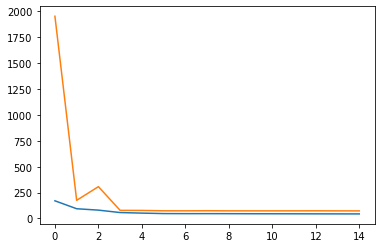

In [24]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

## Absolute Mean Error Losses

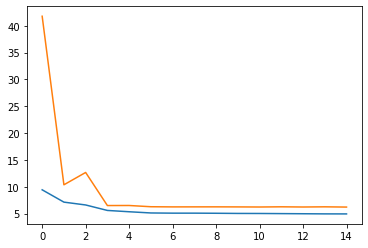

In [26]:
plt.plot(r.history['mean_absolute_error'])
plt.plot(r.history['val_mean_absolute_error'])

# Edades predichas

In [30]:
pred_test_Age = model.predict(test_img)
test_age = np.array(test_age,'int32')
pred_test_Age = np.reshape(pred_test_Age,(len(test_age),))
test_age = np.reshape(test_age,(len(test_age),))
test_images = np.reshape(test_img,(len(test_img),48,48))

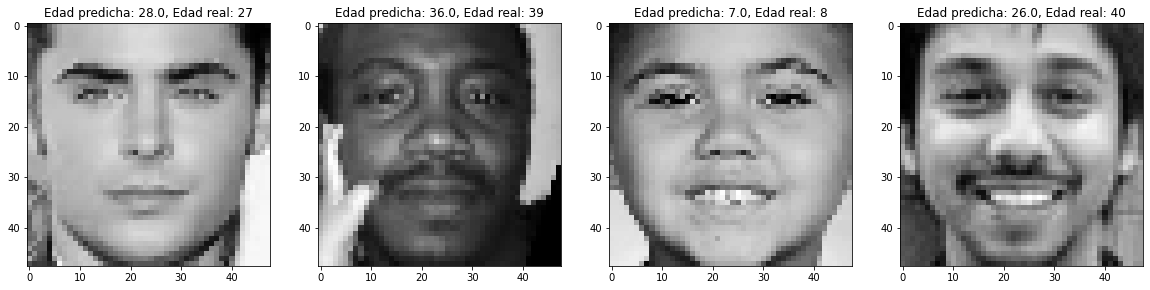

In [31]:
plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(1,4,(i%4)+1):
    plt.title(f"Edad predicha: {np.round(pred_test_Age[i])}, Edad real: {test_age[i]}")
    plt.imshow(test_images[i],cmap='gray')
plt.show()